In [1]:
# import libraries, packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import scipy.optimize
import pandas as pd
import random

In [7]:
# USER PARAMETERS ADJUST BEFORE USING
# lender's beliefs about group probabilities of repayment
pi_w = 0.5 
pi_b = 0.3

#distribution of creditworthy individuals in w/b
w_credit = 0.5
b_credit = 0.25

# benefit of getting a loan to a borrower
benefit = 10
x_q = 10 # net return to lender if qualified borrower gets loan, q = qualified
x_u = -5 # net loss to lender if unqualified borrower gets loan, u = unqualified
ratio = abs(x_q / x_u) # ratio of net gain to loss
# change in lender's perceptions? (how creditworthiness improves)
alpha = 0.05

# INCOMPLETE cost to become creditworthy. Cost varies for each member but is the same distribution for the both groups
cost = 0
# INCOMPLETE fraction of workers that choose to become creditworthy G(c)


In [8]:
# Borrower: each borrower has a group membership (and group creditworthiness signal), individual signal (theta), and actual credtiworthiness
# true if group w, false if group b
# theta = borrower noisy signal
# pi = group signal
class Borrower:
  def __init__(self, group, theta, is_qualified, pi = None):
    self._group = group
    if group:
      self._pi = pi_w
    else:
      self._pi = pi_b      
    self._theta = theta
    self._is_qualified = is_qualified

  @property
  def group(self):
        return self._group
  @property
  def theta(self):
        return self._theta
  @property
  def pi(self):
        return self._pi
  @property
  def is_qualified(self):
      return self._is_qualified
  
  def __str__(self):
        name = "w" if self.group else "b"

        return f"Group: {name}, is_qualified: {self._is_qualified * 1}, theta: {self.theta}, pi: {self.pi}"
  
# Intialize simulation distributions
# create whatever number of objects
# create the actual signals based on the proportion, then create a noisy signal theta
# FLAG LETS TALK ABOUT NOISE
  # def __init__(self, group, theta, is_qualified, pi = None):

def create_borrowers(group, qualified_percentage, total_objects=4):
    borrowers = []
    qualified_count = int(total_objects * qualified_percentage)
    for _ in range(qualified_count):
        theta = 1 - abs(random.gauss(0, 0.25))
        theta = max(0, min(1, theta))
        borrowers.append(Borrower(group, theta, True))
    
    for _ in range(total_objects - qualified_count):
        theta = abs(random.gauss(0, 0.25))
        theta = max(0, min(1, theta))
        borrowers.append(Borrower(group, theta, False))
    
    return borrowers

# groups of borrowers for simulation
b = create_borrowers(False, b_credit)
w = create_borrowers(True, w_credit)

q = [borrower for borrower in b+w if borrower.is_qualified]
u = [borrower for borrower in b+w if not borrower.is_qualified]

for x in b+w:
    print(x)


Group: b, is_qualified: 1, theta: 0.6894716563783421, pi: 0.3
Group: b, is_qualified: 0, theta: 0.38510337237432124, pi: 0.3
Group: b, is_qualified: 0, theta: 0.12460740942537686, pi: 0.3
Group: b, is_qualified: 0, theta: 0.46484136995493996, pi: 0.3
Group: w, is_qualified: 1, theta: 0.8888464374104801, pi: 0.5
Group: w, is_qualified: 1, theta: 0.9829663258450778, pi: 0.5
Group: w, is_qualified: 0, theta: 0.050430234259553376, pi: 0.5
Group: w, is_qualified: 0, theta: 0.17487935627417953, pi: 0.5


Functions

In [14]:
generate_pdf(q)

{0.69: 0.3333333333333333, 0.89: 0.3333333333333333, 0.98: 0.3333333333333333}

In [11]:

# probability signal does not exceed theta in F_q(theta)
def signal_probability(set, given_theta):
    if not 0 <= given_theta <= 1:
        raise ValueError("Threshold must be between 0 and 1")
    count = sum(1 for individual in set if individual.theta <= given_theta)
    return count / len(set) if set else 0.0

# density functions for signal probability, helper function to generate the pdf
# should theere be rounding in this function?
# This is the problem here !! This is not the actual PDF. 
def generate_pdf(group):
    total_borrowers = len(group)
    if total_borrowers == 0:
        raise ValueError("The borrowers list is empty")
    
    theta_counts = {}
    for borrower in group:
        theta = round(borrower.theta, 2)
        if theta in theta_counts:
            theta_counts[theta] += 1
        else:
            theta_counts[theta] = 1

    # Convert counts to probabilities
    pdf = {theta: count / total_borrowers for theta, count in theta_counts.items()}
    return pdf

# gives the specific pdf value of a group given theta
def signal_pdf(group, given_theta):
    if not 0 <= given_theta <= 1:
        raise ValueError("given_theta must be between 0 and 1")

    # Generate the PDF
    pdf = generate_pdf(group)

    # Sum the probabilities for theta values less than x
    sum_prob = sum(prob for theta, prob in pdf.items() if theta < given_theta)

    return sum_prob

# liklihood ratio at a given theta
def likelihood_ratio(given_theta):
    q_value = signal_pdf(q, given_theta)
    u_value = signal_pdf(u, given_theta)
    if q_value == 0:
        return 1
    
    return  u_value / q_value
    
# Lender's posterior probability borrower is qualified
def qualified_prob(borrower):
    pi = borrower.pi
    if pi == 0:
            raise ValueError("pi should not be zero.")
    if pi == 1:
            raise ValueError("pi should not be one.")
    return 1 / (1+(((1-pi)/pi) * likelihood_ratio(borrower.theta)))

# Lender's expected payoff from lending to anyone
def payoff(borrower):
    return qualified_prob(borrower) * x_q - (1-qualified_prob(borrower)) * x_u


#lender lends iff
def employer_assignment(borrower):
    return ratio >= ((1-borrower.pi)/(borrower.pi))*likelihood_ratio(borrower.theta)


# how employer determines the standard s*
# minimum value of theta such that r > [(1-pi/pi)*liklihood]
# the standard is set differently per group
def standard(group, theta_bounds=(0, 1), tol=1e-6):
    def inequality(theta):
        pi = pi_w if group else pi_b
        compare_value = (1 - pi) / pi
        likelihood = likelihood_ratio(theta)
        result = ratio - (compare_value * likelihood)
        print(f"theta: {theta:.4f}, group: {'W' if group else 'B'}, likelihood: {likelihood:.4f}, inequality: {result:.4f}")
        return result
    
        zero = None
    for theta in np.linspace(0, 1, 500):
        if inequality(theta) > 0:
            return theta

    return None
    
    # instead of solving the root equation, we only have to find the lowest(minimum) value of theta such that inequality is greater than zero.
 
    # # FLAG if there's no solution, then the lender lends to no one, and the credit standard is `100%`
    # if np.sign(inequality(0)) == np.sign(inequality(1)):
    #     print("MEGA FLAG")
    #     print(inequality(0))
    #     print(inequality(1))
    #     return 1

    # Use a numerical solver to find the root within the given bounds
    # root = scipy.optimize.fsolve(inequality, x0=0.5, args=(group,))

    # result = scipy.optimize.root_scalar(inequality, bracket=theta_bounds, method='brentq', xtol=tol)

    # if not result.converged:
    #     raise ValueError("Solver did not converge to a solution")

    # return result
    

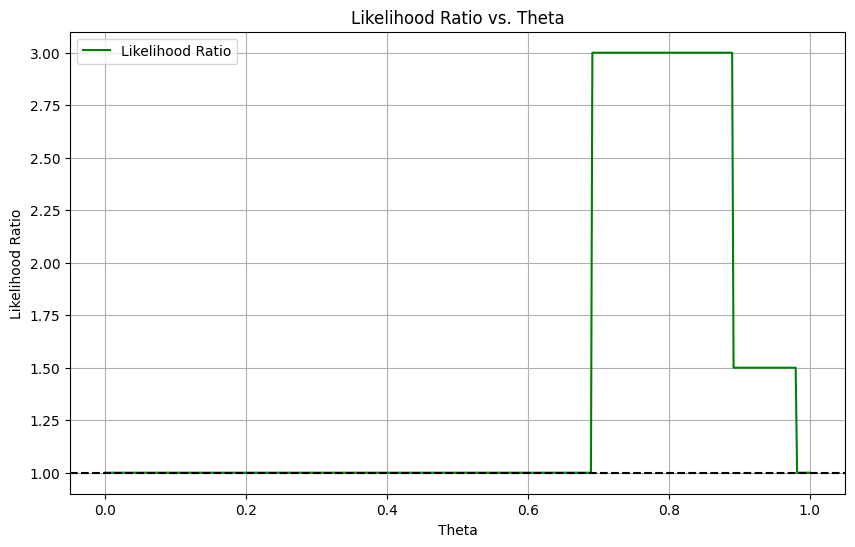

theta: 0.0000, group: W, likelihood: 1.0000, inequality: 1.0000
0.0
theta: 0.0000, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0020, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0040, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0060, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0080, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0100, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0120, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0140, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0160, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0180, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0200, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0220, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0240, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0261, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 0.0281, group: 

In [12]:

# Generate values for theta and calculate likelihood ratio for each
theta_values = np.linspace(0, 1, 500)
likelihood_ratios = [likelihood_ratio(theta) for theta in theta_values]

# Plot the likelihood ratios
plt.figure(figsize=(10, 6))
plt.plot(theta_values, likelihood_ratios, label='Likelihood Ratio', color='green')
plt.axhline(1, color='black', linestyle='--')
plt.xlabel('Theta')
plt.ylabel('Likelihood Ratio')
plt.title('Likelihood Ratio vs. Theta')
plt.legend()
plt.grid(True)
plt.show()

def inequality_2(theta, group):
    pi = pi_w if group else pi_b
    compare_value = (1 - pi) / pi
    return ratio - (compare_value * likelihood_ratio(theta))

# Find roots using fsolve
# def find_root(group, initial_guess=0.5):
#     root = scipy.optimize.fsolve(inequality_2, x0=initial_guess, args=(group,))
#     return root[0]

# # Generate values for theta and calculate inequality for each
# theta_values = np.linspace(0, 1, 500)
# inequality_values_w = [inequality(theta, True) for theta in theta_values]
# inequality_values_b = [inequality(theta, False) for theta in theta_values]

# Find roots
# root_w = find_root(True)
# root_b = find_root(False)

# print(root_w)
# print(root_w)

print(standard(True))
print(standard(False))

In [16]:
# issue is the solver function, giving wrong standard values

def simulate():
    standard_b = standard(False)
    standard_w = standard(True)

    return standard_b, standard_w

print(simulate())

theta: 0.0000, group: B, likelihood: 1.0000, inequality: -0.3333
theta: 1.0000, group: B, likelihood: 1.0163, inequality: -0.3713


ValueError: f(a) and f(b) must have different signs